XLTRC2 Conversion
============================

In [2]:
import ross as rs
from bokeh.io import output_notebook, show
import numpy as np
import matplotlib.pyplot as plt
from xlwings import Book

output_notebook()

Loading BokehJS ...

In [3]:
XLTRC2_filename = "Modelo XLTRC2.xls" # Insert the name of the file from which to load to model

wb = Book(XLTRC2_filename)

n_lines = 0

while wb.sheets['Model'][20+n_lines,0].value != None:
    n_lines += 1

model = wb.sheets['Model']['A21:K'+str(20+n_lines)].value
model = np.array(model)
model[:,10] = model[:,10]==1

disks = []

for i in range(26):
    if wb.sheets['More']['A'+str(6+i)].value != None:
        disks.append(rs.DiskElement(n=int(wb.sheets['More']['A'+str(6+i)].value)-1,
                                  m=wb.sheets['More']['B'+str(6+i)].value,
                                  Ip=wb.sheets['More']['C'+str(6+i)].value,
                                  Id=wb.sheets['More']['D'+str(6+i)].value))

mat = []

for i in range(10):
    if wb.sheets['Model']['K'+str(5+i)].value != None:
        mat.append(rs.Material(name="Mat"+str(i+1), rho=wb.sheets['Model']['N'+str(5+i)].value,
                                     E=wb.sheets['Model']['O'+str(5+i)].value,
                                     G_s=wb.sheets['Model']['P'+str(5+i)].value))


In [5]:

shaft_elements = [
    rs.ShaftElement(
        n=int(model[i,1])-1,
        L=model[i,4],
        odl=model[i,5],
        idl=model[i,6],
        odr=model[i,7],
        idr=model[i,8],
        material=mat[int(model[i,9]-1)],
        shear_effects=model[i,10],
        rotary_inertia=True,
        gyroscopic=True,
    )
    for i in range(n_lines)
]


## BearingElement

This class can be used to represent bearings and support elements.
The following code demonstrate how to properly instantiate it.

In [9]:
brg_file = 'BRG_max_stiff_DE.xls' # Insert filename from which to load bearing data


bearing0 = rs.BearingElement.from_table(n=9, # Insert node for bearing0
                                        file=brg_file,sheet_name='XLUseKCM')

bearing1 = rs.BearingElement.from_table(n=50, # Insert node for bearing1
                                        file=brg_file,sheet_name='XLUseKCM')

bearings = [bearing0, bearing1]

### Instantiating bearings from excel archives

There's a class method to instantiate a bearing from excel files, as we can see in the following code.

## Rotor

This class takes as argument lists with all elements program and assembles the mass, gyroscopic, damping and stiffness global matrices for the system. The object created has several methods that can be used to evaluate the dynamics of the model (they all start with `.run_`.
To use this class, you only have to give all the already instantiated elements in a list format, as it follows.

In [7]:
rotor1 = rs.Rotor(
    shaft_elements,
    disks,
    bearings 
)

### Visualizing the Rotor

It is interesting to plot the rotor to check if the geometry checks with what you wanted to model, you can plot it with the following code.

Note: For almost every plot functions, there are two options for plots, one with bokeh library and one with matplotlib. You can choose this with `plot_type='matplotlib` or `plot_type='bokeh'`. The default for most plot is the bokeh output.

In [10]:
r=rotor1.plot_rotor(plot_type='bokeh')
show(r)

# Running the simulation

After you verify that everything is fine with the rotor, you should 
run the simulation and obtain results.
To do that you only need to use the one of the `.run_()` methods available, as shown in like the code bellow. 

In [107]:
rotor_speed = 10834/60*2*np.pi
modal = rotor1.run_modal(rotor_speed)
print(modal.log_dec)
print(modal.wn*60/(2*np.pi))

[0.29615687 0.29785354 2.93478216 2.87583785 3.83285503 0.19468195]
[ 5811.56434553  5885.6422419  15841.09087921 16528.83881094
 22255.23568104 21031.89191591]


## Obtaining results

These are the following analysis you can do with the program:
- Static analysis
- Campbell Diagram
- Frequency response
- Unbalance response
- Time response
- Orbit response
- Mode Shapes

### Static analysis

This method gives a free body diagram and a amplificated plot of the rotor response to gravity effects.

In [15]:
static = rotor1.run_static()

In [17]:
show(static.plot_deformation())
show(static.plot_free_body_diagram())
show(static.plot_shearing_force())
show(static.plot_bending_moment())

### Campbell Diagram

In this example we can see the campbell diagram from 0 to 200 rad/s (~1900 RPM).

In [115]:
campbell = rotor1.run_campbell(np.linspace(200, 11000/60*2*np.pi, 100))
show(campbell.plot(plot_type='bokeh'))

### Frenquency Response

We can put the frequency response of selecting the input and output degree of freedom.
- Input is the degree of freedom to be excited;
- Output is the degree of freedom to be observed.

In [1]:
response = rotor1.run_freq_response(np.linspace(200, 10834/60*2*np.pi, 100))

show(response.plot(inp=0,out=0,plot_type='bokeh'))

NameError: name 'rotor1' is not defined

### Unbalance Response

This method returns the unbalanced response for a mdof system given magnitide and phase of the unbalance, the node where it's applied and a frequency range.

```text
    node : list, int
        Node where the unbalance is applied.
    magnitude : list, float
        Unbalance magnitude (kg.m)
    phase : list, float
        Unbalance phase (rad)
    frequency_range : list, float
        Array with the desired range of frequencies
```

In this following example, we can obtain the response for a given unbalance (kg.m) and its respective phase in a selected node. Notice that it's possible to add multiple unbalances instantiating node, magnitude and phase as lists.

In [8]:
node = 55
magnitude = 0.08
phase = 0
frequency_range=np.linspace(100, 10834/60*2*np.pi, 100)

unbalance = rotor1.unbalance_response(node, magnitude, phase, frequency_range)
show(unbalance.plot(dof=13, plot_type="bokeh"))

### Time Response

This function will take a rotor object and plot its time response given a force and a time.

This function takes the following parameters:
```text
    F : array
        Force array (needs to have the same number of rows as time array and the number of columns as dof's).
        Each column corresponds to a dof and each row to a time.
    t : array
        Time array.
    dof : int
        Degree of freedom that will be observed.
```

In [27]:
speed = 100.0
size = 1000
dof = 13
t = np.linspace(0, 10, size)
F = np.zeros((size, rotor1.ndof))
F[:, 4 * node] = 10 * np.cos(2 * t)
F[:, 4 * node + 1] = 10 * np.sin(2 * t)
response = rotor1.run_time_response(speed, F, t, dof)
show(response.plot(plot_type="bokeh"))

### Calculate Orbits

This function will take a rotor object and plot the orbit for a single node (2D graph) or all nodes (3D graph) given a forced and a time arrays .
- 2D plot uses bokeh
- 3D plot uses matplotlib

This function takes the following parameters:
```text
    speed: float
        Rotor speed
    F: array
        Force array (needs to have the same number of rows as time array).
        Each column corresponds to a dof and each row to a time.
    t: array
        Time array.
```

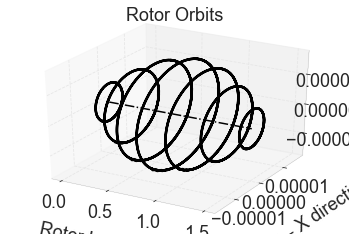

In [49]:
speed = 150.0
size = 1000
node = 3
t = np.linspace(0, 10, size)
F = np.zeros((size, rotor1.ndof))
F[:, 4 * node] = 10 * np.cos(2 * t)
F[:, 4 * node + 1] = 10 * np.sin(2 * t)
response = rotor1.run_orbit_response(speed, F, t)

# plot 3D graph - orbits for all nodes:
response.plot(plot_type="3d")

### Mode Shapes

You can also generate the plot for each mode shape.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1448d780>)

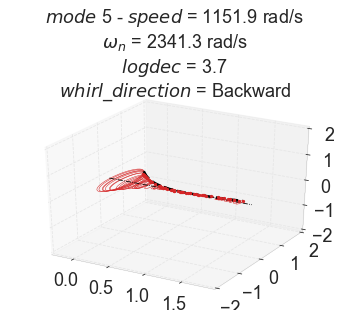

In [114]:
speed = 11000/60*2*np.pi
modes = rotor1.run_modal(speed)
modes.plot_mode(4)